In [4]:
%run utilities.ipynb


In [5]:
model= ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
#model= ChatOpenAI(model="gpt-4o", temperature=0) 
wolfram_tool = load_tools(["wolfram-alpha"])
wolfram_node = ToolNode(tools=[*wolfram_tool])
model_with_tool = model.bind_tools(wolfram_tool)

# Simple agent with one node

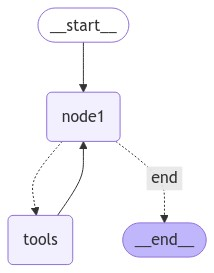

Inside node 1
Inside node 1
Inside node 1
the end


In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
def node1(state:State):
    print("Inside node 1")
    answer=model_with_tool.invoke(state["messages"])
    return {"messages": answer} 
tool_node = wolfram_node


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        print("the end")
        return "end"
    else:
        return "tools"

def init_graph():
    memory = MemorySaver()
    graph_builder = StateGraph(State)    
    graph_builder.add_node("node1", node1)
    graph_builder.add_node("tools", tool_node)
    graph_builder.add_conditional_edges(
        "node1",
#        tools_condition,
#        {"action": "tools", "__end__": "node3"},
        should_continue,
        {"tools":"tools","end":END}
    )


    
# Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "node1")

    graph_builder.set_entry_point("node1")
     
    graph = graph_builder.compile(checkpointer=memory)
    return graph
    
def run_graph(state,graph):       
        thread = {"configurable": {"thread_id": "1"}}
        state = graph.invoke(state,thread)
        return state

graph=init_graph()
state=State()
display(Image(graph.get_graph().draw_mermaid_png()))
query="what is 2^3.45 plus 1. The take the third root. Use this for the upper limit of the integral of log(x) with lower limit 1"
state["messages"] =query

state=run_graph(state,graph)

In [8]:
for i in state["messages"]:
    print(i)

content='what is 2^3.45 plus 1. The take the third root. Use this for the upper limit of the integral of log(x) with lower limit 1' additional_kwargs={} response_metadata={} id='f39a2be3-7569-4e2e-b1fa-8208892dd2c0'
content='' additional_kwargs={'tool_calls': [{'id': 'call_AANLfmDhUvGVBwGZdViG8BPy', 'function': {'arguments': '{"query":"(2^3.45 + 1)^(1/3)"}', 'name': 'wolfram_alpha'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 111, 'total_tokens': 141, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-f10d8923-9f5f-4295-b9b8-71d83c2985ac-0' tool_calls=[{'name': 'wolfram_alpha', 'args': {'query': '(2^3.45 + 1)^(1/3)'}, 'id': 'call_AANLfmDhUvGVB

In [9]:
for i in state["messages"]:
    print(i.content)

what is 2^3.45 plus 1. The take the third root. Use this for the upper limit of the integral of log(x) with lower limit 1

Assumption: (2^3.45 + 1)^(1/3) 
Answer: 2.28486...

Assumption: integral_1^2.28486 log(x) dx = 0.603131 
Answer: integral_1^2.28486 log(x) dx = 0.603131
The value of \( 2^{3.45} + 1 \) to the power of \( \frac{1}{3} \) is approximately 2.28486. 

Using this value as the upper limit, the integral of \( \log(x) \) from 1 to approximately 2.28486 is equal to 0.603131.


# Math agent with 2 nodes

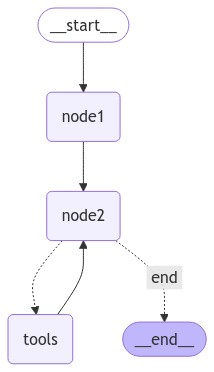

Inside node 1
Inside node 2
Inside node 2
the end


In [10]:
class State(TypedDict):
    task:str
    answer:str
    messages: Annotated[list, add_messages]

def node1(state:State):
    print("Inside node 1")
    answer=model.invoke(state["task"])
    return {"messages": answer} 

def node2(state:State):
    print("Inside node 2")
    answer=model_with_tool.invoke(state["messages"])
    return {"answer":answer,"messages": answer} 


tool_node = wolfram_node


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        print("the end")
        return "end"
    else:
        return "tools"

def init_graph():
    memory = MemorySaver()
    graph_builder = StateGraph(State)    
    graph_builder.add_node("node1", node1)
    graph_builder.add_node("node2", node2)
    graph_builder.add_edge("node1", "node2")
    
    graph_builder.add_node("tools", tool_node)
    graph_builder.add_conditional_edges(
        "node2",
#        tools_condition,
#        {"action": "tools", "__end__": "node3"},
        should_continue,
        {"tools":"tools","end":END}
    )


    
# Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "node2")

    graph_builder.set_entry_point("node1")
     
    graph = graph_builder.compile(checkpointer=memory)
    return graph
    
def run_graph(state,graph):       
        thread = {"configurable": {"thread_id": "1"}}
        state = graph.invoke(state,thread)
        return state

graph=init_graph()
state=State()
display(Image(graph.get_graph().draw_mermaid_png()))
state["task"] ="Create a math problem involving an integral. Use numbers for the integral limits and solve"

state=run_graph(state,graph)

In [11]:
for i in state["messages"]:
    print(i)

content='Find the integral of f(x) = 2x^2 + 3x - 1 from x = 1 to x = 4.\n\nTo solve this problem, we first need to find the antiderivative of f(x):\nF(x) = (2/3)x^3 + (3/2)x^2 - x\n\nNext, we evaluate F(x) at the upper and lower limits of integration:\nF(4) = (2/3)(4)^3 + (3/2)(4)^2 - 4 = 85.33\nF(1) = (2/3)(1)^3 + (3/2)(1)^2 - 1 = 1.5\n\nFinally, we find the definite integral by subtracting the lower limit from the upper limit:\n∫[1,4] (2x^2 + 3x - 1) dx = F(4) - F(1) = 85.33 - 1.5 = 83.83\n\nTherefore, the integral of f(x) from x = 1 to x = 4 is 83.83.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 23, 'total_tokens': 261, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'log

In [12]:
for i in state["messages"]:
    print(i.name)
    print(i.content)
    

None
Find the integral of f(x) = 2x^2 + 3x - 1 from x = 1 to x = 4.

To solve this problem, we first need to find the antiderivative of f(x):
F(x) = (2/3)x^3 + (3/2)x^2 - x

Next, we evaluate F(x) at the upper and lower limits of integration:
F(4) = (2/3)(4)^3 + (3/2)(4)^2 - 4 = 85.33
F(1) = (2/3)(1)^3 + (3/2)(1)^2 - 1 = 1.5

Finally, we find the definite integral by subtracting the lower limit from the upper limit:
∫[1,4] (2x^2 + 3x - 1) dx = F(4) - F(1) = 85.33 - 1.5 = 83.83

Therefore, the integral of f(x) from x = 1 to x = 4 is 83.83.
None

wolfram_alpha
Assumption: integral_1^4 (2 x^2 + 3 x - 1) dx = 123/2 = 61.5 
Answer: integral_1^4 (2 x^2 + 3 x - 1) dx = 123/2 = 61.5
None
The integral of \(2x^2 + 3x - 1\) from \(x = 1\) to \(x = 4\) is \(\frac{123}{2}\) or 61.5.


# Exercise: Change such that the problem is generated in node1 and afterwards solved in node2 with help of the math tool

## Solution

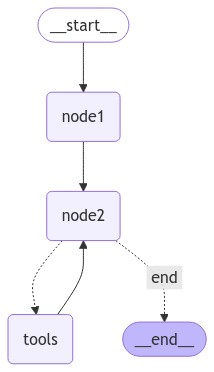

Inside node 1
Inside node 2
Inside node 2
the end


In [31]:
def get_SOLVE_PROMPT (problem):
    SOLVE_PROMPT =f""" 

    Use the provided Wolram Tool to solve the Problem:
    {problem}
    
    ### Follow the instructions below:
        
    1. **Step-by-Step Solution**:
       - Provide a detailed, step-by-step solution to the problem, ensuring clarity at each stage.
       - Explain each step thoroughly to make the reasoning easy to follow and ensure that each part of the process is justified.
    
    2. **Solution Review**:
       - Explain in detail the meaning of the solution in the given context.
    
    """
    return SOLVE_PROMPT

class State(TypedDict):
    task:str
    problem:str
    messages: Annotated[list, add_messages]

def node1(state:State):
    print("Inside node 1")
    answer=model.invoke(state["task"])
    solve_prompt=get_SOLVE_PROMPT(answer)
    return {"messages":solve_prompt,"problem":answer} 

def node2(state:State):
    print("Inside node 2")
    answer=model_with_tool.invoke(state["messages"])
    return {"messages": answer} 


tool_node = wolfram_node


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        print("the end")
        return "end"
    else:
        return "tools"

def init_graph():
    memory = MemorySaver()
    graph_builder = StateGraph(State)    
    graph_builder.add_node("node1", node1)
    graph_builder.add_node("node2", node2)
    graph_builder.add_edge("node1", "node2")
    
    graph_builder.add_node("tools", tool_node)
    graph_builder.add_conditional_edges(
        "node2",
#        tools_condition,
#        {"action": "tools", "__end__": "node3"},
        should_continue,
        {"tools":"tools","end":END}
    )


    
# Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "node2")

    graph_builder.set_entry_point("node1")
     
    graph = graph_builder.compile(checkpointer=memory)
    return graph
    
def run_graph(state,graph):       
        thread = {"configurable": {"thread_id": "1"}}
        state = graph.invoke(state,thread)
        return state

graph=init_graph()
state=State()
display(Image(graph.get_graph().draw_mermaid_png()))
state["task"] ="Create a math problem involving an integral. Do not solve the problem. Use numbers for the integral limits."
state=run_graph(state,graph)

In [32]:
print(state["problem"])

content='Find the integral of f(x) = 2x^2 + 3x - 1 from x = 0 to x = 5.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 28, 'total_tokens': 59, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-5025e513-78a0-4649-876b-66bc9e416290-0' usage_metadata={'input_tokens': 28, 'output_tokens': 31, 'total_tokens': 59}


In [29]:
for i in state["messages"]:
    print(i.name)
    print(i.content)

None
 

    Use the provided Wolram Tool to solve the Problem:
    content='Find the integral of f(x) = 2x^2 + 3x - 1 from x = 0 to x = 5.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 28, 'total_tokens': 59, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-2b89837f-3491-46d7-a930-1cd08db161ab-0' usage_metadata={'input_tokens': 28, 'output_tokens': 31, 'total_tokens': 59}
    
    ### Follow the instructions below:
        
    1. **Step-by-Step Solution**:
       - Provide a detailed, step-by-step solution to the problem, ensuring clarity at each stage.
       - Explain each step thoroughly to make the reasoning easy to follow and ensure that each par